In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polire.placement import NottDuns, Stationary
from polire.interpolate import Kriging
from IPython.display import clear_output

TabError: inconsistent use of tabs and spaces in indentation (base.py, line 219)

## Resample and clean

In [8]:
tdata = pd.read_pickle('../dataset/TempData.pickle')
tdata = tdata['2004-02-28':'2004-03-01']
loc_df = pd.read_csv('../dataset/mote_locs.txt', sep=' ',names=[0,'X','Y']).set_index(0)

M = 22
cross_df = pd.crosstab(tdata.index, tdata.ID, tdata.Temp, aggfunc=lambda x:list(x)[0])
cross_df = cross_df.resample(str(M)+'min').mean().dropna(how='any')
print(cross_df.shape, len(cross_df.dropna()), cross_df.cov().dropna().shape)

G_all = (((cross_df - cross_df.mean()).T).dot(cross_df - cross_df.mean())/len(cross_df)) # Estim. Cov. Mat.
G_all_npcov = cross_df.cov()
train_data = loc_df.loc[cross_df.columns][['X','Y']]
train_data['Temp'] = cross_df.mean()

train_data = train_data.reset_index(drop=True)
G_all = pd.DataFrame(G_all.values, index=range(len(train_data)), columns=range(len(train_data)))

(181, 52) 181 (52, 52)


## Creating initial deployment

In [9]:
Seed = 42
train_sample = train_data.sample(10, random_state=Seed)
G = G_all.loc[train_sample.index, train_sample.index]

X_train = train_sample[['X','Y']].values
y_train = train_sample[['Temp']].values

## Training with stationary and NS kernel

In [10]:
nonStat = NottDuns(N=5, eta=1, kernel_name='m32')
nonStat.fit(X_train, y_train, G.values)

Stat = Stationary(1, 'm32')
Stat.fit(X_train, y_train, G.values)

Optimization restart 1/1, f = 18.31987830195559


## 30 Placements with Greedy Algorithm

In [11]:
NN = 30
Pilot_ind = train_sample.index.tolist()
A_ind_MI, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='MI')
A_ind_Var, _ = nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='Entropy')
MI = nonStat.MI
Var = nonStat.Var

A_ind_MI1, _ = Stat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='MI')
A_ind_Var1, _ = Stat.place(train_data[['X', 'Y']].values, Pilot_ind, N=NN, method='Entropy')
MI1 = Stat.MI
Var1 = Stat.Var

## 100 random placements

In [12]:
T = 100
MI_master = np.zeros((len(MI), T))

for trial in range(T):
    clear_output(True)
    print(trial)
    nonStat.place(train_data[['X', 'Y']].values, Pilot_ind, NN, method='Rand', random_state=trial)
    MI_master[:, trial] = nonStat.MI_rand
    
T = 100
MI_master1 = np.zeros((len(MI), T))

for trial in range(T):
    clear_output(True)
    print(trial)
    Stat.place(train_data[['X', 'Y']].values, Pilot_ind, NN, method='Rand', random_state=trial)
    MI_master1[:, trial] = Stat.MI_rand

99


## Plot 100 random v/s greedy

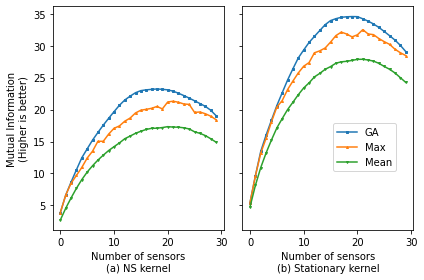

In [13]:
MM = 2
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(range(0, len(MI)), np.cumsum(0.5*np.log(MI)), 's-',label='GA', markersize=MM)
ax[0].plot(range(0, len(MI)), np.cumsum(0.5*np.log(MI_master),axis=0).max(axis=1), '^-'
        ,label='Max', markersize=MM)
ax[0].plot(range(0, len(MI)), np.cumsum(0.5*np.log(MI_master),axis=0).mean(axis=1), 'v-'
        ,label='Mean', markersize=MM)

ax[1].plot(range(0, len(MI1)), np.cumsum(0.5*np.log(MI1)), 's-',label='GA', markersize=MM)
ax[1].plot(range(0, len(MI1)), np.cumsum(0.5*np.log(MI_master1),axis=0).max(axis=1), '^-'
        ,label='Max', markersize=MM)
ax[1].plot(range(0, len(MI1)), np.cumsum(0.5*np.log(MI_master1),axis=0).mean(axis=1), 'v-'
        ,label='Mean', markersize=MM)

ax[1].legend(bbox_to_anchor=(.5,.5))
ax[0].set_xlabel('Number of sensors\n(a) NS kernel')
ax[1].set_xlabel('Number of sensors\n(b) Stationary kernel')
ax[0].set_ylabel('Mutual Information\n(Higher is better)')
plt.tight_layout()
plt.show()